# Introduction
This document describes the analysis that took place before writing the final report.

## Loading dependencies

In [25]:
# loading libraries
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
import numpy as np
from keras.utils import np_utils

from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
%matplotlib inline
import seaborn as sns

from keras.preprocessing import image  
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D, Input
from keras.models import Sequential, Model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras import optimizers

from tqdm import tqdm

import os
import random
import shutil
import itertools

## Loading data

In [26]:
# loading data
data = load_files('/seedlings-data/train', load_content=False, shuffle=False)

print(f"There are {len(data['target_names'])} categories")
print (f"These categories are {data['target_names']}")
print (f"There are {len(data['filenames'])} images in training dataset")

There are 12 categories
These categories are ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
There are 4750 images in training dataset


## Visualizations

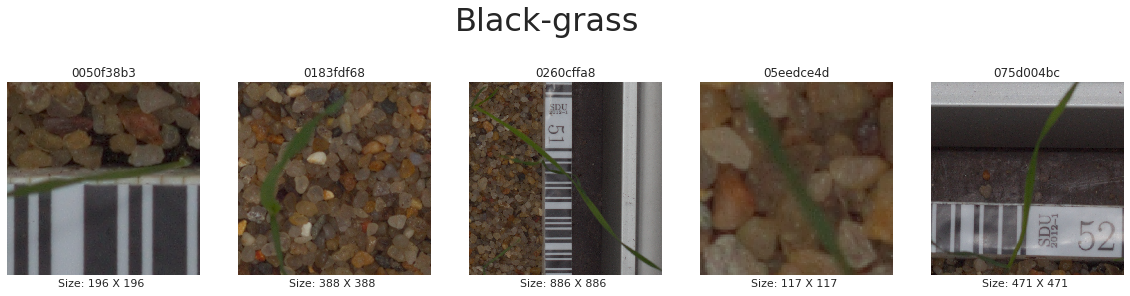

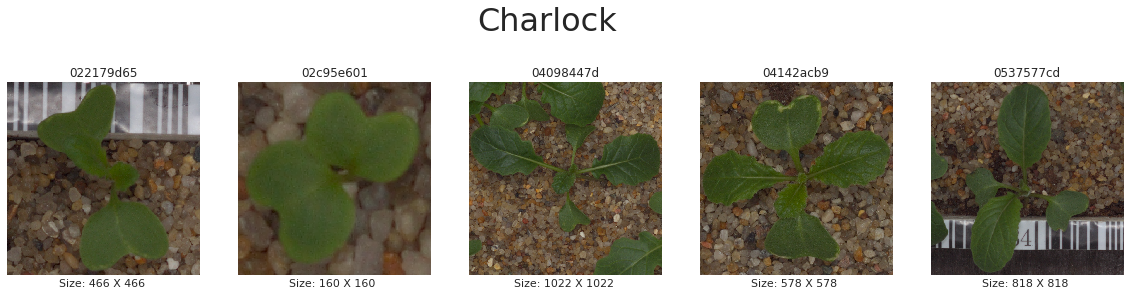

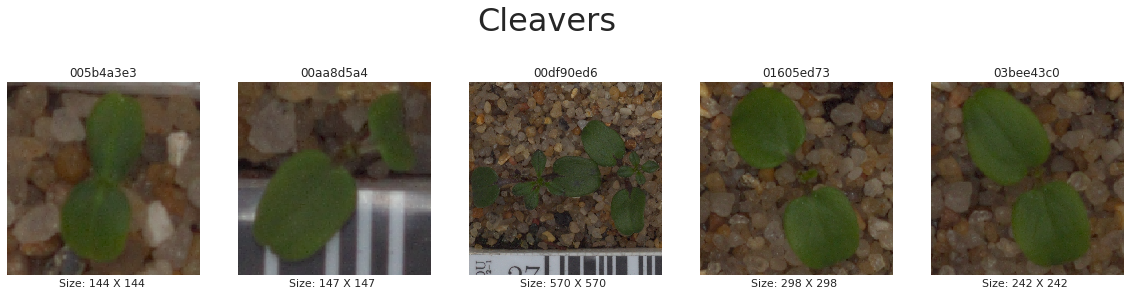

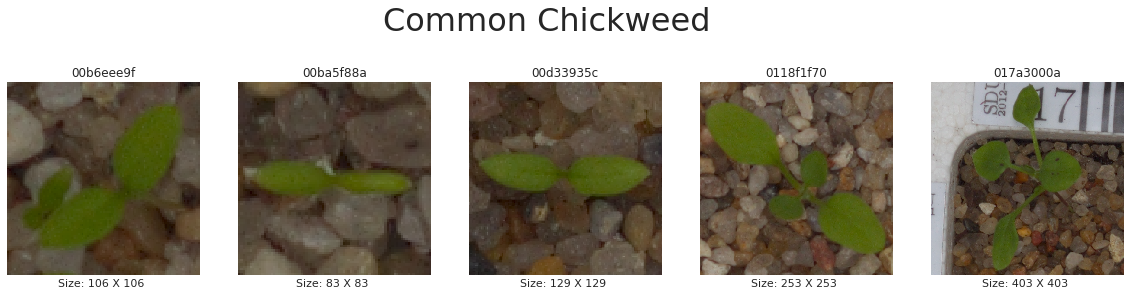

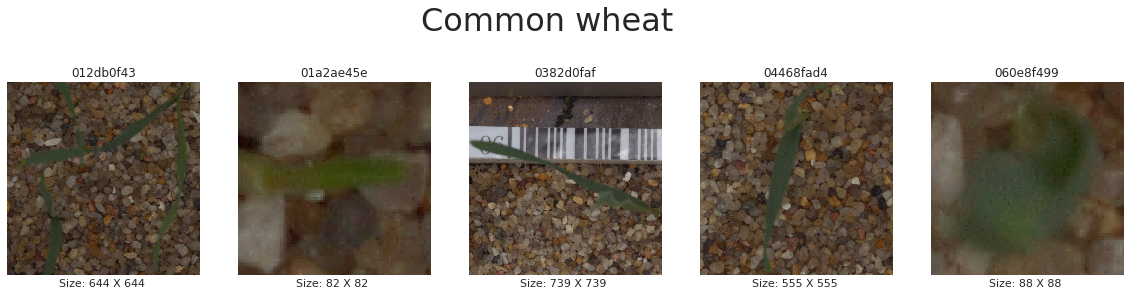

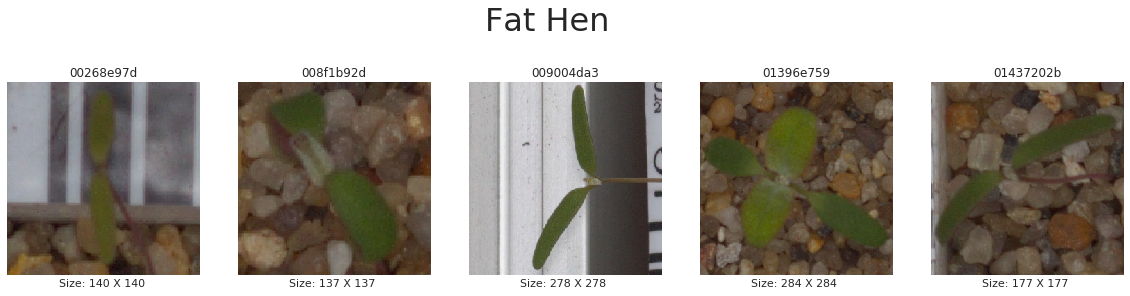

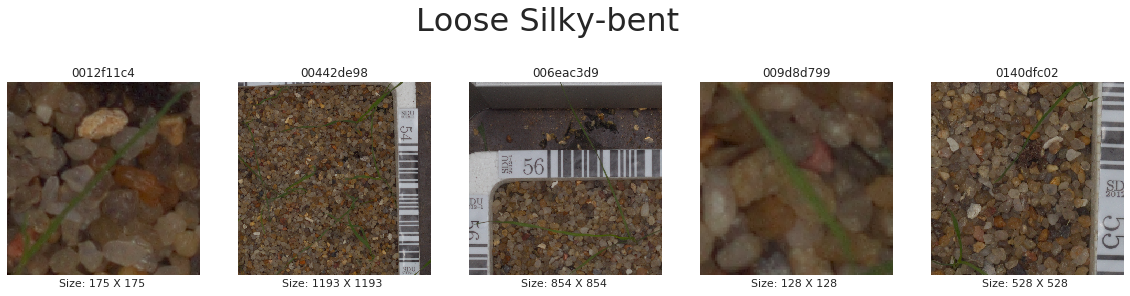

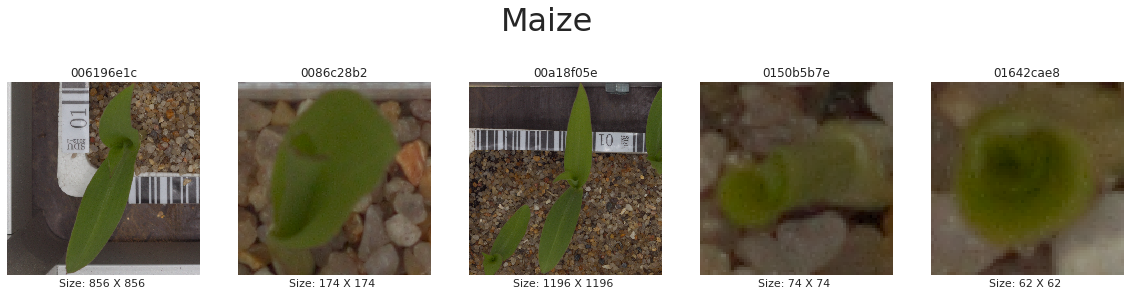

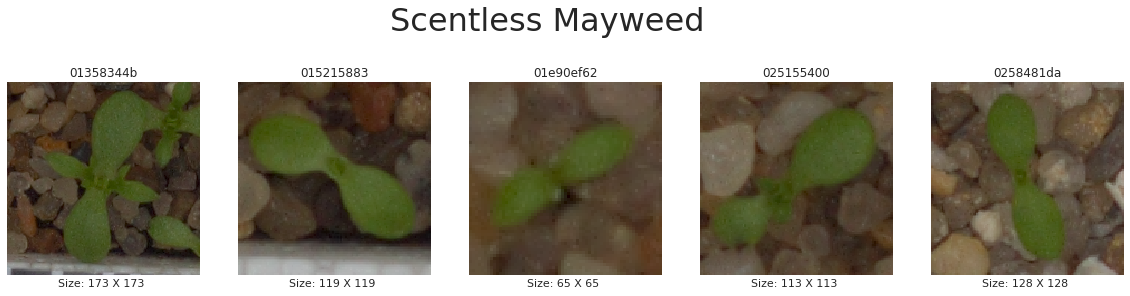

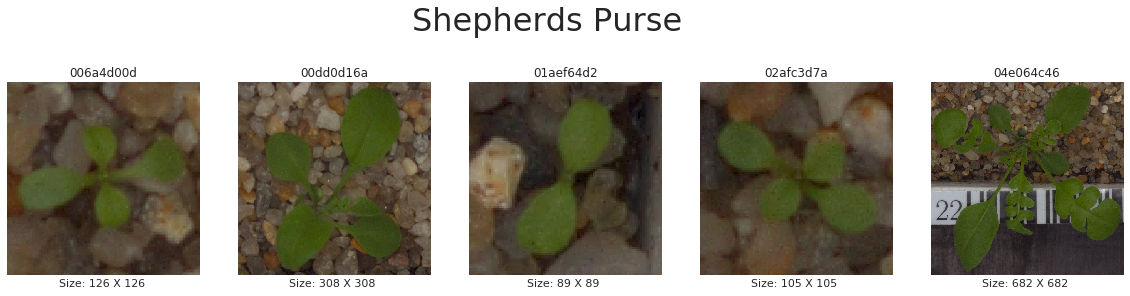

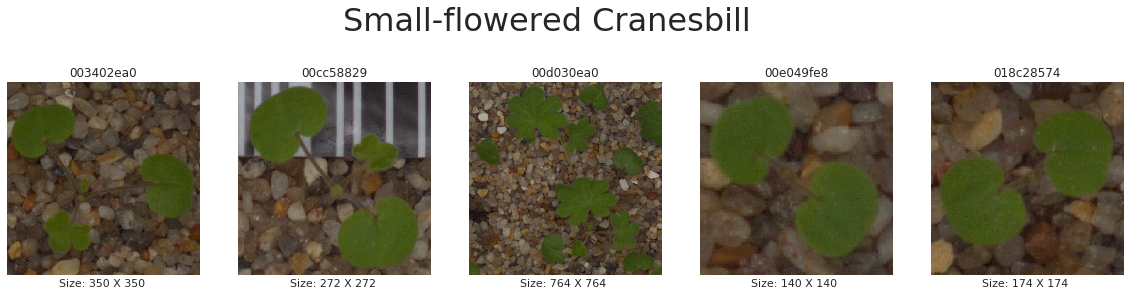

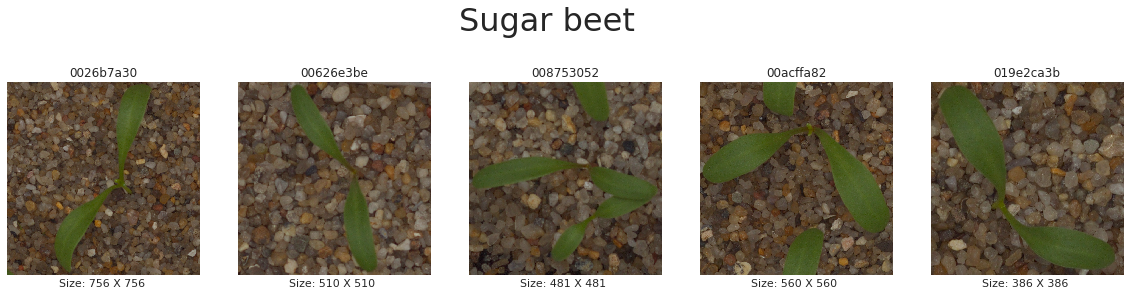

In [27]:
"""
Show 5 samples of each plant species
Each image's title is its filename. Each image's subtitle is it's height and width in pixels.
"""
def display_sample_images(n=5):
    for seedling_id in range(len(data['target_names'])):
        fig = plt.figure(figsize=(20,5))
        fig.suptitle(data['target_names'][seedling_id], fontsize=32)
        img_list = [i for i, j in enumerate(data['target']) if j == seedling_id]
        for i in range(n):
            seedling_file = data['filenames'][img_list[i]]
            filename = seedling_file[-13:-4]
            with Image.open(seedling_file) as img:
                ax = fig.add_subplot(1, n, i+1, xticks=[], yticks=[])
                ax.set_title(filename)
                ax.set_xlabel("Size: %d X %d " % (img.size[0], img.size[1]))
                ax.imshow(mpimg.imread(seedling_file))
        plt.show()

display_sample_images()

## Splitting data into train and test set

In [28]:
"""
Spliting data into a training and a testing set.
"""
def split_data_train_and_test(data, test_section = 0.1):
    x = np.array(data['filenames'])
    y = np.array(data['target'])
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_section, random_state=0)
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = split_data_train_and_test(data)

## One hot encoding targets

In [29]:
"""
Targets are one-hot-encoded by converting them from integers to vectors with a length 
equal to the number of plant species
"""
y_train_targets = np_utils.to_categorical(y_train, len(data['target_names']))
y_test_targets = np_utils.to_categorical(y_test, len(data['target_names']))

## Plot the plant distribution

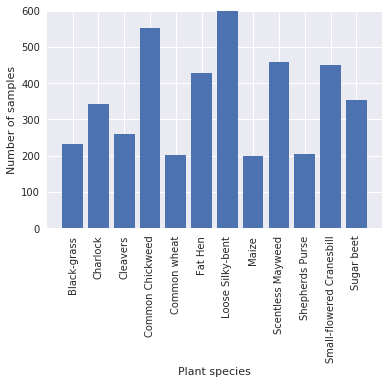

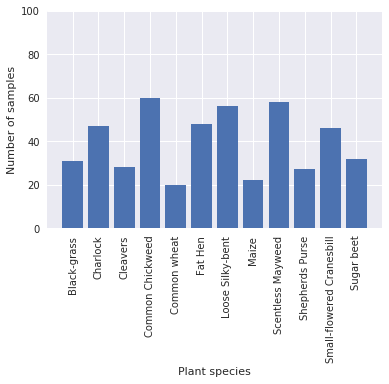

In [30]:
"""
Plot the distribution of samples across all plant species
"""
def plot_class_distribution(targets, ylim):
    labels = np.array(data['target_names']) 
    fig, ax = plt.subplots()
    x_pos = np.arange(len(labels))
    train_labels = np.sum(targets, axis=0)
    ax.bar(x_pos, train_labels, align='center')
    ax.set_ylim(0, ylim)
    plt.xticks(x_pos, labels, rotation='vertical')
    plt.xlabel("Plant species")
    plt.ylabel("Number of samples")
    plt.show()

sns.set(color_codes=True) 
plot_class_distribution(y_train_targets, 600)
plot_class_distribution(y_test_targets, 100)

## Images to tensors

In [31]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensors(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [32]:
# Create the tensors from x_train and x_test
x_train_tensors = paths_to_tensors(x_train)
x_test_tensors = paths_to_tensors(x_test)

100%|██████████| 475/475 [00:05<00:00, 83.00it/s] 


## Augmenting data
The data augmentation I used was based on
[https://machinelearningmastery.com/image-augmentation-deep-learning-keras/](https://machinelearningmastery.com/image-augmentation-deep-learning-keras/) and 
[https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and [https://arxiv.org/pdf/1712.04621.pdf](https://arxiv.org/pdf/1712.04621.pdf)

In [33]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [34]:
def empty_augmented_data_directory(path):
    if os.path.isdir(path): 
        shutil.rmtree(path)
    os.makedirs(path)


def image_augmentation(x_train_tensors, y_train, labels, batch_size):
    path = '/output/augmented_images'
    empty_augmented_data_directory(path)
    for seedling_id in range(len(data['target_names'])):
        target_dir = '%s/%s' % (path, labels[seedling_id])
        os.makedirs(target_dir)
        
        images = [i for i, j in enumerate(y_train) if j == seedling_id]
        random.shuffle(images)
        
        images = (images * (batch_size // len(images))) + images[0:batch_size % len(images)]        

        n_images = x_train_tensors[images]
        for batch in datagen.flow(n_images, batch_size=batch_size, save_to_dir=target_dir, save_format='png'):
            break

In [35]:
# The augmented data only needs to be created once. As it takes a long time to create 
# and I pay floydhub.com by the minute the following line is commented out.
#image_augmentation(x_train_tensors, y_train, np.array(data['target_names']), 2500)

In [36]:
# The augmented_images were downloaded and uploaded back to floydhub as a dataset
augmented_data = load_files('/augmented_images', load_content=False, shuffle=False)
print (f"There are {len(augmented_data['filenames'])} images in training dataset")

There are 30000 images in training dataset


In [37]:
# Naturally the augmented images have to be tensorized and hot_encoded also
x_augmented = np.array(augmented_data['filenames'])
x_augmented_tensors = paths_to_tensors(x_augmented)
y_augmented = np.array(augmented_data['target'])
y_augmented_targets = np_utils.to_categorical(y_augmented, len(data['target_names']))

100%|██████████| 30000/30000 [01:15<00:00, 397.49it/s]


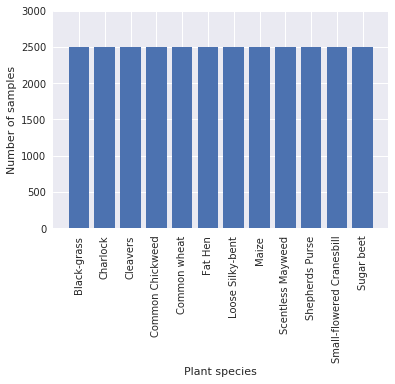

In [38]:
# plotting the augmented data
sns.set(color_codes=True) 
plot_class_distribution(y_augmented_targets, 3000)

## Calculating f1 score
For reasons unclear to me F1 is not offered as a [metric in Keras](https://keras.io/metrics/).
Fortunately my good friends Google and Stackoverflow know everything The code below comes from [stackoverflow](https://stackoverflow.com/questions/43547402/how-to-calculate-f1-macro-in-keras)


In [39]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Training method

In [40]:
"""
Train a model. 
Parameters:
 model: The model to train.
 x: x_train_tensors or x_augmented_tensors.
 y: y_train_targets or y_augmented_targets.
 epochs: Number of epochs
"""
def train_model(model, x, y, epochs):
    checkpointer = ModelCheckpoint(filepath=f"/output/weights.best.from_{model.name}.hdf5", 
                               verbose=1, save_best_only=True)

    model.fit(x, y, validation_data=(x_test_tensors, y_test_targets),
              epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

## Evaluation functions

In [41]:
"""
    This code comes from the scikit-learn documentation 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
"""
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
"""
Evaluate the results of a model. Displaying confusion matrix (normalized and not not normalized) and F1 score
"""
def evaluate_model(model):
    model.load_weights(f"/output/weights.best.from_{model.name}.hdf5")
    y_pred = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in x_test_tensors]
    y_test = np.argmax(y_test_targets, axis=1)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    class_names = np.array(data['target_names'])
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
    
    # Plot normalized confusion matrix
    plt.figure(figsize=(15,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()
    
    f1 = f1_score(y_test, y_pred, average='micro')
    print(f"{model.name} F1 Score: {f1}")

In [43]:
def train_and_evaluate(model, x, y, epochs):
    train_model(model, x, y, epochs)
    evaluate_model(model)

## Defining a homemade CNN
Starting with the same model I used on the dog classifier project 

In [44]:
def create_basic_model():
    basic_model = Sequential()
    basic_model.name = 'basic_model'
    
    basic_model.add(Conv2D(filters=16,kernel_size=2,strides=1,activation='relu',input_shape=x_train_tensors[0].shape))
    basic_model.add(MaxPooling2D(pool_size=2,strides=2))
    
    #basic_model.add(Dropout(0.33))
    basic_model.add(Conv2D(filters=32, kernel_size=2,strides=1,activation='relu'))
    basic_model.add(MaxPooling2D(pool_size=2,strides=2))
    #basic_model.add(Dropout(0.33))
    basic_model.add(Conv2D(filters=64, kernel_size=2,strides=1,activation='relu'))
    basic_model.add(MaxPooling2D(pool_size=2,strides=2))
    #basic_model.add(Dropout(0.33))
    basic_model.add(Conv2D(filters=128, kernel_size=2,strides=1,activation='relu'))
    basic_model.add(MaxPooling2D(pool_size=2,strides=2))
    basic_model.add(Conv2D(filters=256, kernel_size=2,strides=1,activation='relu'))
    basic_model.add(MaxPooling2D(pool_size=2,strides=2))
    
    basic_model.add(GlobalAveragePooling2D())
    
    basic_model.add(Dense(len(data['target_names']),activation='softmax'))
    basic_model.summary()
    basic_model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=[f1])
    return basic_model

## VGG-19
Inspired by [this medium article](https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8)

In [45]:
def create_vgg19_model():
    # include_top is used to remove the top layers
    vgg_start_model = VGG19(weights = "imagenet", include_top=False, input_shape=x_train_tensors[0].shape)
    
    # Freeze top layers
    freeze_layers = 5
    for layer in vgg_start_model.layers[:freeze_layers]:
        layer.trainable = False
    x = vgg_start_model.output
    x = Flatten()(x)
    
    x = Dense(1024, activation="relu")(x)
    predictions = Dense(len(data['target_names']), activation="softmax")(x)
    VGG19_model = Model(input = vgg_start_model.input, output = predictions)
    VGG19_model.name = 'vgg_model'
    VGG19_model.summary()
    VGG19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])
    return VGG19_model
# Add custom layers 
#x = vgg_start_model.output
#x = Flatten()(x)
#predictions = Dense(len(data['target_names']), activation='softmax')(x)

# include_top is used to remove the top layers
#vgg_start_model = VGG19(weights="imagenet", include_top=False, input_shape=x_train_tensors[0].shape)

# Freeze all layers
#for layer in vgg_start_model.layers:
#    layer.trainable = False

In [46]:
# Creating the VGG19 model 
#VGG19_model = Model(input = vgg_start_model.input, output = predictions)
#VGG19_model.name = 'vgg_model'
#VGG19_model.summary()
# re-add the removed layers
#x = vgg_start_model.output
#x = Flatten(name="flatten")(x)
#x = Dense(4096, activation="relu", name="fc1")(x)
#x = Dropout(0.5)(x)
#x = Dense(4096, activation="relu", name="fc2")(x)
#x = Dropout(0.5)(x)
#x = Dense(len(data['target_names']), activation="softmax", name="predictions")(x)
#VGG19_model = Model(inputs=vgg_start_model.input, outputs=x, name="final_model")

#x = vgg_start_model.output
#x = Flatten()(x)
#x = Dense(1024, activation="relu")(x)
#x = Dropout(0.5)(x)
#x = Dense(1024, activation="relu")(x)
#predictions = Dense(len(data['target_names']), activation="softmax")(x)
#VGG19_model = Model(input = vgg_start_model.input, output = predictions)
#VGG19_model.name = 'vgg_model'
#VGG19_model.summary()

In [47]:
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
#VGG19_model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=[f1])
#VGG19_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

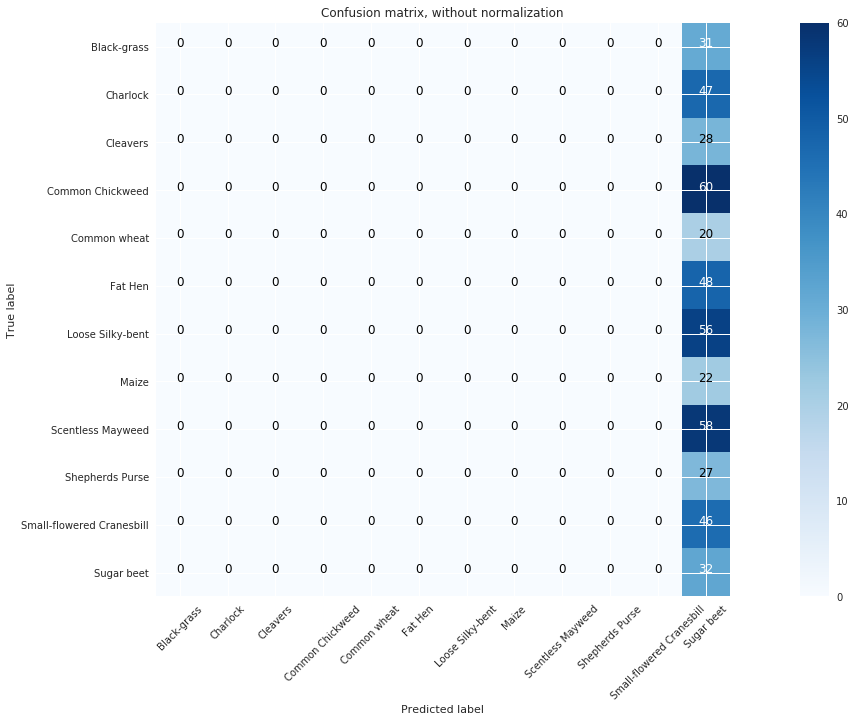

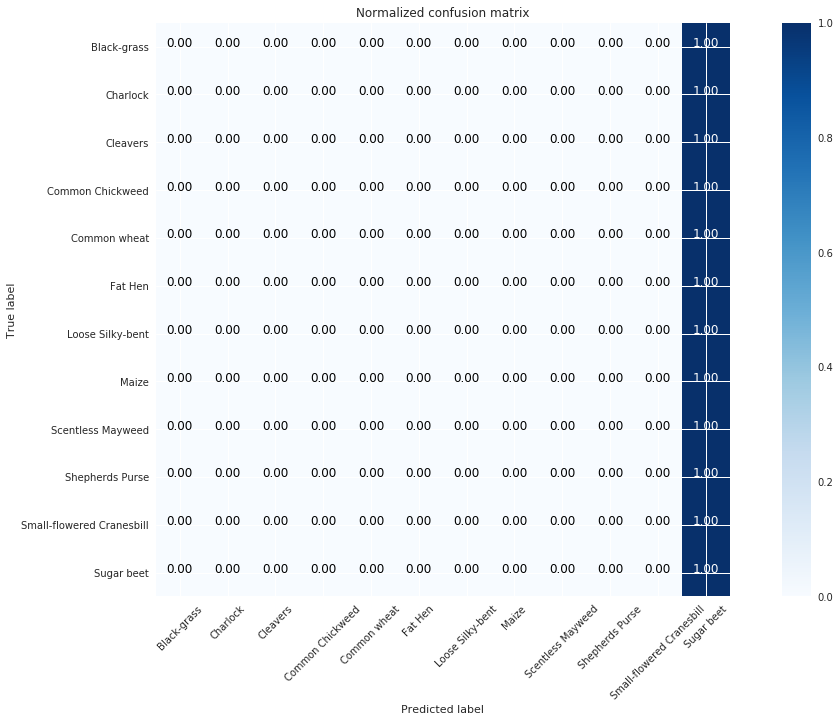

vgg_model F1 Score: 0.06736842105263158


In [48]:
#basic_model = create_basic_model()
#train_and_evaluate(basic_model, x_train_tensors, y_train_targets, 20)
#train_and_evaluate(basic_model, x_augmented_tensors, y_augmented_targets, 20)

VGG19_model = create_vgg19_model()
train_and_evaluate(VGG19_model, x_train_tensors, y_train_targets, 5)
#train_and_evaluate(VGG19_model, x_augmented_tensors, y_augmented_targets, 10)